In [1]:
from keywords import *

path = "../pdf-reports/"
pdf = read_plaintext_with_keywords(path)

In [2]:
pdf.head()

,filename,title,keywords,topics,text,metadata,num_keywords,num_topics
0,8th-enisa-workshop-certs-in-europe-report,8th ENISA Workshop ‘CERTs in Europe’,[CSIRTs],[],\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2014-01-10T16:07:35Z', 'dat...",1,0
1,a-collection-of-good-practice-for-cert-quality...,,[],"[CSIRTs in Europe, CSIRT Cooperation]",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2009-06-22T13:09:55Z', 'dat...",0,2
2,a-security-analysis-of-next-generation-web-sta...,a-security-analysis-of-next-generation-web-sta...,[],"[Internet Infrastructure, Understanding the im...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2011-08-02T13:37:24Z', 'dat...",0,3
3,actionable-information-for-security,actionable-information-for-security,[CSIRTs],"[CSIRT Services, Reactive Services]",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2015-01-19T07:28:32Z', 'dat...",1,2
4,algorithms-key-size-and-parameters-report-2014,algorithms-key-size-and-parameters-report-2014,[Privacy],"[Cryptographic protocols and tools, Security o...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2014-11-20T13:30:49Z', 'dat...",1,2


In [3]:
def remove_multiple_empty_lines(s):
    """Remove multiple empty lines.
    
    The pdf documents contain a lot of whitespace. This function removes multiple empty lines.
    The idea is to keep at most two consecutive newline characters because
    two consecutive newline characters will be used to split the text into an array of paragraphs.
    """
    
    return re.sub(r'\n(\n)+', '\n\n', s, flags=re.MULTILINE)

print(remove_multiple_empty_lines('ahoj\n\nahoj\n\n\nahoj\nahoj'))

ahoj

ahoj

ahoj
ahoj


In [4]:
def is_whitespace(s):
    """Returns true if the string consists of whitespace characters only."""
    return bool(re.match("^\s+$", s)) | (len(s) == 0)

print(is_whitespace("\n \t  "))
print(is_whitespace("ahoj\n \t  "))
print(is_whitespace("\n \t  ahoj"))
print(is_whitespace(""))

True
False
False
True


In [5]:
def to_paragraphs(s):
    """Split the text of the document into paragraphs."""
    ps = remove_multiple_empty_lines(s).split('\n\n')
    return [p for p in ps if not is_whitespace(p)]

In [6]:
def to_sentences(s):
    """Split the text of the document into sentences."""
    ps = remove_multiple_empty_lines(s).split('\n')
    return [p for p in ps if not is_whitespace(p)]

In [7]:
def remove_until_ISBN(ps):
    """Removes all text before ISBN.
    
    The ENISA pdf documents start with the text about ENISA, acknowledgements and legal notice.
    The legal notice section is the last one to appear before the table of contents.
    The last paragraph in the legal notice section is the ISBN number.
    We can use this function to have the document starting with the table of contents.
    However, not all documents follow this structure.
    
    Arguments:
        ps: Array of paragraphs. Each paragraph is a string.
    
    Returns:
        Array of paragraphs without the ones until the ISBN number.
    """
    
    for i, p in enumerate(ps):
        if bool(re.match("^ISBN:.+doi:", p)):
            return ps[i+1:]

print(remove_until_ISBN(['ahoj', 'ISBN: 978-92-9204-184-7 | doi: 10.2824/87614', 'ahoj', 'ISBN: 978-92-9204-184-7']))

['ahoj', 'ISBN: 978-92-9204-184-7']


In [8]:
CONTENTS = ['table of contents', 'contents']
RECOMMENDATIONS = ['recommendations', 'detailed recommendations', 'general recommendations']
SUMMARY = ['executive summary', 'management summary', 'summary', 'conclusions', 'preface']

def is_title(s):
    """Returns true if the string is a chapter title.
    
    Any string starting with a number is considered a title if it does not contain a URL.
    Apart from such strings, we also check for common titles that often appear in the pdf documents
    and are not preceded with any chapter number.
    """
    
    common_titles = CONTENTS + RECOMMENDATIONS + SUMMARY + [
        'about ENISA', 'contact details', 'credits', 'acknowlegements', 'legal notice',
        'glossary', 'annex', 'appendix']
    for ct in common_titles:
        #if bool(re.match("^[0-9,.]*\s*{}".format(ct), s.lower())):
        if bool(re.match("^[0-9]*[.]*\s*{}".format(ct), s.lower())):
            return True
    
    return(
           #bool(re.match("^[0-9,.]+\s+\S+", s)) and
           bool(re.match("^[0-9]+[.]*\s+\S+", s)) and
           not bool(re.match(r'.*\s+\bhttp\S+', s)))

print(is_title("1. Introduction"))
print(is_title("1.2 Introduction"))
print(is_title("1,2 Introduction"))
print(is_title("Introduction 1"))
print(is_title("Recommendations"))
print(is_title("9 See http://ec.europa.eu/transport/index_en.htm"))
print(is_title("4\n http://www.team-cymru.org/"))
print(is_title("1.2"))

True
False
False
False
True
False
False
False


In [9]:
def strip_title(s):
    title = s.lower().strip()
           
    # Remove whitespace and anything beyond ...
    i = title.find("...")
    if i > -1:
        title = title[:i].strip()
                
    # Remove page number at the end.
    title = re.compile("([0-9]+|[ivxlcdm]+)$").sub("", title).strip()
    
    # Remove the section number at the beginning
    #title = re.compile("^[0-9,.]+\s+").sub("", title).strip()
    
    return title
    
print(strip_title("Executive summary iii"))
print(strip_title("1 Introduction 12"))
print(strip_title("1 Introduction ..."))

executive summary
1 introduction
1 introduction


In [10]:
def get_titles(ps, found_table_of_contents, stop_on_duplicates):
    """Find chapter titles.

    Parameters:
        found_table_of_contents: If true, the chapter title search will start from the beginning of the document,
            i.e. as if the table of contents have been found already.
            If false, the chapter title search will start after the table of contents are found.
        stop_on_duplicates: If true, the chapter title search will stop once duplicate titles are found.
            This usually appears once the actual titles start appearing after the listing in the table of contents.
            Note that duplicates will never be returned.
            This flag is introduced only to avoid getting false titles from the body text.
    
    Returns:
        List of unique chapter titles.
    """

    titles = list()
    for p in ps:
        if is_title(p):
            title = strip_title(p)

            if title in CONTENTS:
                found_table_of_contents = True

            # If found_table_of_contents == True,
            # start adding titles to the list once the table of contents section starts.
            if found_table_of_contents:
                # If stop_on_duplicates == True,
                # stop searching for chapter titles once duplicates are detected after the table of contents.
                # We assume that once a duplicate appears, we are already beyond the table of contents section,
                # in the first chapter of the document.
                # This is to protect against getting false titles identified in the body text.
                if title in titles and stop_on_duplicates:
                    break
                if not title in titles:
                    titles.append(title)
    return titles

text = """Table of Contents

Executive Summary iii

1 Introduction 12

Executive Summary

This is the executive summary.

1 Introduction

This is the introduction.
"""
titles = get_titles(to_paragraphs(text), True, False)
titles

['table of contents', 'executive summary', '1 introduction']

In [11]:
def get_chapters(ps, titles):
    chapter_start = list()
    past_table_of_contents = False
    for i, p in enumerate(ps):
        # Apply the changes that are used for the titles to every paragraph.
        # This is necessary becasue we will be comparing every paragraph to the titles.
        s = strip_title(p)
    
        if s in titles:
            chapter_start.append(i)
#        # The actual chapter start after the table of contents.
#        if past_table_of_contents and s in titles:
#            chapter_start.append(i)
#        if s in CONTENTS:
#            past_table_of_contents = True
        
    chapter_end = [i for i in chapter_start[1:]]
    chapter_end.append(len(ps))
    
    chapters = dict()
    for start, end in zip(chapter_start, chapter_end):
        title = strip_title(ps[start])
        text = "\n\n".join(ps[start:end])
        if title in chapters.keys():
            chapters[title] += "\n" + text
        else:
            chapters[title] = text
    
    return chapters

chapters = get_chapters(to_paragraphs(text), titles)
chapters

{'1 introduction': '1 Introduction 12\n1 Introduction\n\nThis is the introduction.\n',
 'executive summary': 'Executive Summary iii\nExecutive Summary\n\nThis is the executive summary.',
 'table of contents': 'Table of Contents'}

In [12]:
def get_recommendations(chapters):
    keys = chapters.keys()
    s = ""
    for key in keys:
        # Remove the section number at the beginning
        key_without_number = re.compile("^[0-9,.]+\s+").sub("", key).strip()
        if key_without_number in RECOMMENDATIONS:
            s += chapters[key]
    return s

print(get_recommendations(chapters))

In [13]:
def get_summary(chapters):
    keys = chapters.keys()
    s = ""
    for key in keys:
        # Remove the section number at the beginning
        key_without_number = re.compile("^[0-9,.]+\s+").sub("", key).strip()
        if key_without_number in SUMMARY:
            s += chapters[key]
    return s

print(get_summary(chapters))

Executive Summary iii
Executive Summary

This is the executive summary.


In [14]:
text0 = pdf.at[2, 'text']
text0

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n  \n\nJuly 2011 \n\nA Security Analysis of  \n\nNext Generation Web Standards  \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n  \n\n\n\n \n\n  \n\nAbout ENISA \n\nThe European Network and Information Security Agency (ENISA) is an EU agency created \nto advance the functioning of the internal market. ENISA is a centre of expertise for the \nEuropean Member States and European institutions in network and information security, \ngiving advice and recommendations and acting as a switchboard of information for good \npractices. Moreover, the agency facilitates contacts between the European institutions, the \nMember States, private business and industry actors. \n\nContact details: \n\nEditors: Dr. Giles Hogben (giles.hogbenQenisa.europa.eu) and Dr. Marnix Dekker \n(marnix.dekkerQenisa.europa.eu) \n\nAuthors: Philippe De Ryck, Lieven Desmet, Pieter Philippaerts, and Frank Piessens, \nKatholieke Unive

In [15]:
ps = to_paragraphs(text0)
#ps = to_sentences(text0)
len(ps)

1500

In [16]:
paragraph_length = [len(p) for p in ps]

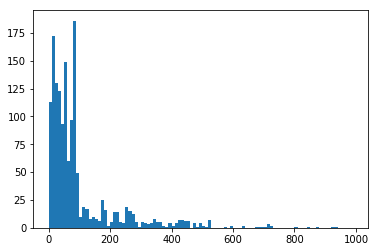

In [17]:
import matplotlib.pyplot as plt

plt.hist(paragraph_length, bins=np.arange(0, 1000, 10))
plt.show()

In [18]:
for p in ps:
    if len(p) < 10:
        print(len(p), repr(p))

8 'Credits '
2 '2 '
2 '3 '
2 '4 '
2 '5 '
9 '1. Scope '
2 '6 '
2 '7 '
9 'UMP      '
5 '   2 '
6 '3   1 '
2 '8 '
2 '9 '
3 '10 '
5 'work '
8 'yes yes '
3 '11 '
3 '12 '
3 '13 '
3 '14 '
3 '15 '
3 '16 '
3 '17 '
3 '18 '
3 '19 '
3 '20 '
6 'Model '
9 'Media API'
7 'Sandbox'
3 '21 '
3 'UI '
3 '22 '
3 '23 '
3 '24 '
3 '25 '
3 '26 '
3 '27 '
3 '28 '
3 '29 '
5 'of B '
3 '30 '
8 'Origin A'
8 'Origin B'
8 'Origin B'
8 'Origin A'
8 'Origin A'
8 'Origin A'
8 'Origin B'
8 'Origin C'
8 'Origin A'
8 'Origin B'
8 'Origin A'
8 'Origin A'
3 '31 '
8 'network '
3 '32 '
8 'request '
9 'manifest '
3 '33 '
3 '34 '
3 '35 '
5 'URLs '
3 '36 '
7 'stack) '
3 '37 '
3 '38 '
3 '39 '
9 'reasons. '
2 'p2'
7 'Phase 1'
7 'Phase 2'
7 'Phase 3'
3 '40 '
3 '41 '
6 'host) '
9 'FormData '
3 '42 '
3 '43 '
9 'o Origin '
8 'effects '
3 '44 '
3 '45 '
9 'cookies) '
9 'accessed '
3 '46 '
8 'Origin A'
1 '1'
8 'Origin B'
1 '2'
3 '47 '
8 'Origin A'
1 '2'
1 '1'
1 '1'
8 'Origin A'
1 '5'
1 '4'
1 '4'
3 '48 '
8 'storage '
3 '49 '
3 '50 '
3 '51 '


In [19]:
lines_per_paragraph = [len(p.split('\n')) for p in ps]

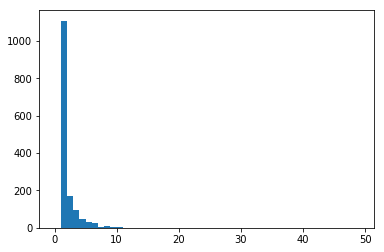

In [20]:
import matplotlib.pyplot as plt

plt.hist(lines_per_paragraph, bins=np.arange(0, 50, 1))
plt.show()

In [21]:
titles = get_titles(ps, found_table_of_contents=False, stop_on_duplicates=True)
titles

['table of contents',
 'executive summary',
 '2. analysis results',
 '3. recommendations',
 '4. security analysis',
 '1. scope',
 '1. inter-component communication (i.e. inter-page messaging)',
 '2. cross-application web communication \n3. least-privilege integration of third-party web components \n4. use of newly-proposed human computing interfaces (media capture, geo-location, …) \n5. storing and retrieving client data in local web storage \nthis multi-tenant focus (illustrated by the system use case scenarios) and the identified \ncategories of security issues scope the assessment to the following specifications:',
 '1. html 5 specification [1]',
 '2. cross-origin messaging specification',
 '3. device api specifications',
 '4. widget specifications']

In [22]:
titles = get_titles(ps, found_table_of_contents=True, stop_on_duplicates=False)
titles

['contact details:',
 'credits',
 'legal notice',
 'executive summary',
 'table of contents',
 '2. analysis results',
 '3. recommendations',
 '4. security analysis',
 '1. scope',
 '1. inter-component communication (i.e. inter-page messaging)',
 '2. cross-application web communication \n3. least-privilege integration of third-party web components \n4. use of newly-proposed human computing interfaces (media capture, geo-location, …) \n5. storing and retrieving client data in local web storage \nthis multi-tenant focus (illustrated by the system use case scenarios) and the identified \ncategories of security issues scope the assessment to the following specifications:',
 '1. html 5 specification [1]',
 '2. cross-origin messaging specification',
 '3. device api specifications',
 '4. widget specifications',
 '3',
 'recommendations will be sent separately to the respective working groups. this applies to \nthe following threats:',
 '1. elements: analysis of elements with relevant changed or 

In [23]:
chapters = get_chapters(ps, titles)
chapters.keys()

dict_keys(['executive summary', '1. html 5 specification [1]', '3. based on the detailed analysis of all specifications, we investigate potential issues with', 'legal notice', "1 this identification of attacker types (web attacker and gadget attacker) is based on the threat \nmodel used in: adam barth, collin jackson, and john c. mitchell. 2008. securing frame \ncommunication in browsers. in proceedings of the 17th conference on security symposium (ss'08). \nusenix association, berkeley, ca, usa, p.17-30.", 'contact details:', '5. application cache: analysis of the application cache, supporting offline applications', 'table of contents', '1. elements: analysis of elements with relevant changed or new functionality in html', '1. scope', '1. a study of the specification leads to a brief summary of relevant functionality', '2. analysis results', 'contents:', '4. widget specifications', '2. cross-origin messaging specification', '3. device api specifications', '3. recommendations', '3. bro

In [24]:
for k, v in chapters.items():
    print(k, len(v))

executive summary 9094
1. html 5 specification [1] 28
3. based on the detailed analysis of all specifications, we investigate potential issues with 61945
legal notice 1008
1 this identification of attacker types (web attacker and gadget attacker) is based on the threat 
model used in: adam barth, collin jackson, and john c. mitchell. 2008. securing frame 
communication in browsers. in proceedings of the 17th conference on security symposium (ss'08). 
usenix association, berkeley, ca, usa, p.17-30. 1467
contact details: 315
5. application cache: analysis of the application cache, supporting offline applications 4151
table of contents 614
1. elements: analysis of elements with relevant changed or new functionality in html 86
1. scope 1133
1. a study of the specification leads to a brief summary of relevant functionality 879
2. analysis results 2537
contents: 8838
4. widget specifications 1764
2. cross-origin messaging specification 185
3. device api specifications 263
3. recommendations 

In [25]:
print(get_recommendations(chapters))

3. Recommendations ....................................................................................................... 12 
3.1. Controlling Functionality ...................................................................................................... 12 
3.2. Consistent Permission Systems ............................................................................................ 13 
3.3. End User Policing ................................................................................................................. 14 
3.4. Restricted Contexts .............................................................................................................. 14 
3.5. General Recommendations .................................................................................................. 14 
3. Recommendations 

In this section, we present concrete recommendations to improve the security of the 
analyzed specifications. The recommendations are based on the threats identified in 

In [26]:
print(get_summary(chapters))

Executive summary 

The web browser is arguably the most security-critical component in our information infrastructure. 
It has become the channel through which most of our information passes. Banking, social 
networking, shopping, navigation, card payments, managing high value cloud services and even 
critical infrastructures such as power networks – almost any activity you can imagine now takes 
place within a browser window. 

This has made browsers an increasingly juicy target for cyber-attacks: the volume of web-based 
attacks per day increased by 93% in 2010 compared to 2009, with 40 million attacks a day recorded 
for September 2010 (Symantec Threat Report, 2010). Many more complex threats such as DDoS 
attacks using botnets rely on flaws in web browsers, which allow the installation of malware. Even if 
the root cause is elsewhere, the browser is often in a position to protect the user – e.g. in 
combatting phishing and pharming etc. 

The standards which govern the browser – a

In [27]:
#def add_chapter_fields(df):
    #df['chapter_titles'] = df['text'].map(lambda x: get_titles(to_paragraphs(x)))
    #df['summary'] = df['text'].map(lambda x: get_summary(get_chapters(to_paragraphs(x))))
    #df['recommendations'] = df['text'].map(lambda x: get_recommendations(get_chapters(to_paragraphs(x))))
    #df['all_chapters'] = df['text'].map(lambda x: '\n\n'.join(list(get_chapters(to_paragraphs(x)).values())))
    #return df

pdf = add_chapter_fields(pdf, paragraphs=True, found_table_of_contents=False, stop_on_duplicates=True)
pdf.head()

,filename,title,keywords,topics,text,metadata,num_keywords,num_topics,chapter_titles,num_chapters,has_table_of_contents,summary,has_summary,recommendations,has_recommendations,all_chapters
0,8th-enisa-workshop-certs-in-europe-report,8th ENISA Workshop ‘CERTs in Europe’,[CSIRTs],[],\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2014-01-10T16:07:35Z', 'dat...",1,0,"[table of contents, executive summary, 1 intro...",8,True,Executive summary \n\nENISA’s traditional work...,True,,False,Executive summary \n\nENISA’s traditional work...
1,a-collection-of-good-practice-for-cert-quality...,,[],"[CSIRTs in Europe, CSIRT Cooperation]",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2009-06-22T13:09:55Z', 'dat...",0,2,"[table of contents, 1 management summary, 2 ac...",10,True,1 Management Summary ............................,True,,False,7 CSIRT internal management .....................
2,a-security-analysis-of-next-generation-web-sta...,a-security-analysis-of-next-generation-web-sta...,[],"[Internet Infrastructure, Understanding the im...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2011-08-02T13:37:24Z', 'dat...",0,3,"[table of contents, executive summary, 2. anal...",12,True,Executive summary \n\nThe web browser is argua...,True,3. Recommendations ..............................,True,Executive summary \n\nThe web browser is argua...
3,actionable-information-for-security,actionable-information-for-security,[CSIRTs],"[CSIRT Services, Reactive Services]",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2015-01-19T07:28:32Z', 'dat...",1,2,"[table of contents, executive summary, 1 intro...",8,True,Executive summary \n\nIn the world of incident...,True,,False,Executive summary \n\nIn the world of incident...
4,algorithms-key-size-and-parameters-report-2014,algorithms-key-size-and-parameters-report-2014,[Privacy],"[Cryptographic protocols and tools, Security o...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"{'Last-Modified': '2014-11-20T13:30:49Z', 'dat...",1,2,"[contents, 1 executive summary, 2 how to read ...",26,True,"Executive Summary\n\nDuring 2013, ENISA prepar...",True,,False,"Executive Summary\n\nDuring 2013, ENISA prepar..."


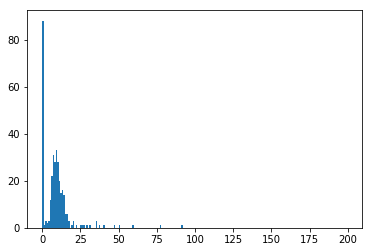

In [28]:
import matplotlib.pyplot as plt

plt.hist(pdf['num_chapters'], bins=np.arange(0, 200, 1))
plt.show()

In [29]:
print(len(pdf))
print(len(pdf[pdf['has_summary']]))
print(len(pdf[pdf['has_recommendations']]))
print(len(pdf[pdf['has_table_of_contents']]))

351
221
57
263


In [30]:
pdf = add_chapter_fields(pdf, paragraphs=True, found_table_of_contents=True, stop_on_duplicates=False)
#pdf.head()

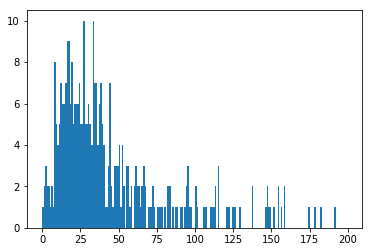

In [31]:
import matplotlib.pyplot as plt

plt.hist(pdf['num_chapters'], bins=np.arange(0, 200, 1))
plt.show()

In [32]:
print(len(pdf[pdf['has_summary']]))
print(len(pdf[pdf['has_recommendations']]))

262
83


In [33]:
pdf = add_chapter_fields(pdf, paragraphs=False, found_table_of_contents=True, stop_on_duplicates=False)
#pdf.head()

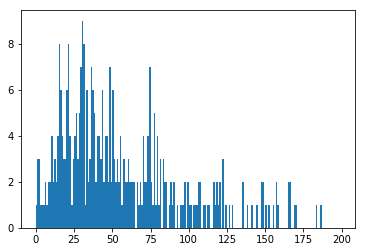

In [34]:
import matplotlib.pyplot as plt

plt.hist(pdf['num_chapters'], bins=np.arange(0, 200, 1))
plt.show()

In [35]:
print(len(pdf[pdf['has_summary']]))
print(len(pdf[pdf['has_recommendations']]))

270
97
